In [54]:
import wandb
import matplotlib.pyplot as plt
import dice_ml
import warnings
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer, roc_auc_score,precision_score, recall_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
# import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
import os
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scripts.SEP_CFE_functions import *



min_max_scaler = MinMaxScaler()
warnings.filterwarnings("ignore")
# scale_factor = 1e8

In [55]:
# --- Patch DiCE PublicData.get_decimal_precisions early to avoid IndexError in empty/malformed modes ---
import dice_ml.data_interfaces.public_data_interface as pdi

def safe_get_decimal_precisions(self, output_type="list"):
    """Return decimal precision per feature safely.

    Returns a list by default (same shape as original DiCE implementation) where each
    index corresponds to the feature order in `self.feature_names`. Also supports
    output_type='dict' to return a mapping {feature_name: precision}.

    This is defensive: if modes are empty or unparsable the default precision is 6.
    """
    from collections import defaultdict
    precisions_dict = defaultdict(int)
    # initialize a list matching feature_names length (default 0)
    precisions_list = [0] * len(self.feature_names)

    for idx, feat in enumerate(self.feature_names):
        # default precision
        precisions_list[idx] = 6
        precisions_dict[feat] = 6

    # Now compute precisions for continuous features only
    for col in self.continuous_feature_names:
        try:
            # determine index of this feature in feature_names
            try:
                ix = self.feature_names.index(col)
            except ValueError:
                # fallback: place precision at leftmost free slot (shouldn't normally happen)
                ix = None

            if (self.continuous_features_precision is not None) and (col in self.continuous_features_precision):
                prec = int(self.continuous_features_precision[col])
            else:
                # only compute modes if dtype is float-like
                if getattr(self.data_df[col], 'dtype', None) in [np.float32, np.float64]:
                    modes = self.data_df[col].mode()
                    if len(modes) == 0:
                        prec = 6
                    else:
                        # compute maximal fractional length among modes
                        maxp = 0
                        for m in modes:
                            s = str(m)
                            if '.' in s:
                                parts = s.split('.')
                                if len(parts) > 1:
                                    maxp = max(maxp, len(parts[1]))
                        prec = maxp if maxp > 0 else 6
                else:
                    prec = 6
            # set into both structures
            if ix is not None:
                precisions_list[ix] = prec
            precisions_dict[col] = prec
        except Exception:
            # any unexpected error -> keep default precision 6
            precisions_dict[col] = 6
            try:
                if ix is not None:
                    precisions_list[ix] = 6
            except Exception:
                pass

    if output_type == "list":
        return precisions_list
    elif output_type == "dict":
        return dict(precisions_dict)
    else:
        # preserve backward compatibility: return list by default for any unknown output_type
        return precisions_list

# Apply the patch so subsequent DiCE calls use this safe version
pdi.PublicData.get_decimal_precisions = safe_get_decimal_precisions

In [56]:
abt_path_train = '../../data/raw/GOES/goes18_2024.csv'
df_train = pd.read_csv(abt_path_train,  sep=',' )
df_train.columns.values[0] = 'timestamp'
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])

In [57]:
def create_and_save_windows(df, save_dir="windows", input_hours=2, pred_hours=2, stride_hours=2):
    os.makedirs(save_dir, exist_ok=True)
    input_len = input_hours * 60     # convert to minutes
    pred_len = pred_hours * 60
    stride = stride_hours * 60
    n = len(df)
    timestamps = df['timestamp']
    window_count = 0

    for start in range(0, n - input_len - pred_len + 1, stride):
        end_input = start + input_len
        end_pred = end_input + pred_len

        input_df = df.iloc[start:end_input]
        pred_df  = df.iloc[end_input:end_pred]

        start_time = timestamps[start].strftime("%Y%m%d_%H%M")
        input_file = os.path.join(save_dir, f"GOES18_2024_{window_count:04d}_{start_time}_input.csv")
        pred_file  = os.path.join(save_dir, f"GOES18_2024_{window_count:04d}_{start_time}_pred.csv")

        input_df.to_csv(input_file)
        pred_df.to_csv(pred_file)
        window_count += 1
    print(f"✅ Created {window_count} overlapping windows in '{save_dir}'")

# Create and save windows with stride = 2 hours
create_and_save_windows(df_train, save_dir="../../data/processed/goes18_2024", input_hours=2, pred_hours=2, stride_hours=2)

✅ Created 4391 overlapping windows in '../../data/processed/goes18_2024'


In [58]:
def create_flare_label_dataset_from_pred(input_pred_dir, save_path=None):
    rows = []
    for file in sorted(os.listdir(input_pred_dir)):
        if file.endswith("_pred.csv"):
            pred_file_path = os.path.join(input_pred_dir, file)
            df_pred = pd.read_csv(pred_file_path)

            max_flux = df_pred['xrsb'].max()
            if max_flux >= 1e-4:
                label = 'X'
            elif max_flux >= 1e-5:
                label = 'M'
            elif max_flux >= 1e-6:
                label = 'C'
            elif max_flux >= 1e-7:
                label = 'B'
            elif max_flux >= 1e-8:
                label = 'A'
            else:
                label = 'NF'

            input_filename = file.replace('_pred', '_input')
            rows.append({'input_filename': input_filename, 'label': label})

    label_df = pd.DataFrame(rows)
    if save_path:
        label_df.to_csv(save_path, index=False)
        print(f"Label dataset saved to: {save_path}")

    return label_df


In [59]:
input_pred_dir = "../../data/processed/goes18_2024"
save_file = "../../data/processed/goes18_2024_labels.csv"

label_df = create_flare_label_dataset_from_pred(input_pred_dir, save_path=save_file)
print(label_df.head())

Label dataset saved to: ../../data/processed/goes18_2024_labels.csv
                             input_filename label
0  GOES18_2024_0000_20240101_0000_input.csv     C
1  GOES18_2024_0001_20240101_0200_input.csv     C
2  GOES18_2024_0002_20240101_0400_input.csv     C
3  GOES18_2024_0003_20240101_0600_input.csv     M
4  GOES18_2024_0004_20240101_0800_input.csv     C


In [60]:
# label_df = pd.read_csv("../../data/processed/goes18_2024_labels.csv")

In [61]:
def recursive_slices(start, end, min_size=5):
    length = end - start
    if length <= min_size:
        return [(start, end)]
    else:
        mid = start + length // 2
        left = recursive_slices(start, mid, min_size)
        right = recursive_slices(mid, end, min_size)
        return [(start, end)] + left + right

def generate_mean_features(df, min_size=5, prefix=None):
    n_timesteps = df.shape[0]
    slices = recursive_slices(0, n_timesteps, min_size)
    features = {}

    for channel in ['xrsa', 'xrsb']:
        data = pd.to_numeric(df[channel], errors='coerce').values
        for (s, e) in slices:
            name = f"{prefix+'_' if prefix else ''}{channel}[{s}:{e}]_mean"
            val = np.mean(data[s:e])

            # Only add feature if val is not NaN
            if not np.isnan(val):
                # features[name] = val*scale_factor
                val = np.log(val.clip(min=1e-10))   # natural log, safe for small values
                features[name] = val

    return pd.Series(features)



In [62]:
def create_mean_features_by_window_sizes(input_dir, output_file, window_sizes=None):
    rows = []
    input_files = sorted([f for f in os.listdir(input_dir) if "_input.csv" in f])
    for file in input_files:
        df = pd.read_csv(os.path.join(input_dir, file))
        features = generate_mean_features(df, min_size=5)
        feature_dict = {'input_filename': file, **features.to_dict()}
        rows.append(feature_dict)

    features_df = pd.DataFrame(rows)
    features_df.dropna(inplace=True)
    features_df.to_csv(output_file, index=False)
    print(f"✅ Mean-valued features saved to: {output_file}")


In [63]:
input_dir = "../../data/processed/goes18_2024/"  # folder containing input files
output_file = "../../data/processed/goes18_2024_mean_features_custom_windows.csv"

create_mean_features_by_window_sizes(input_dir, output_file)

✅ Mean-valued features saved to: ../../data/processed/goes18_2024_mean_features_custom_windows.csv


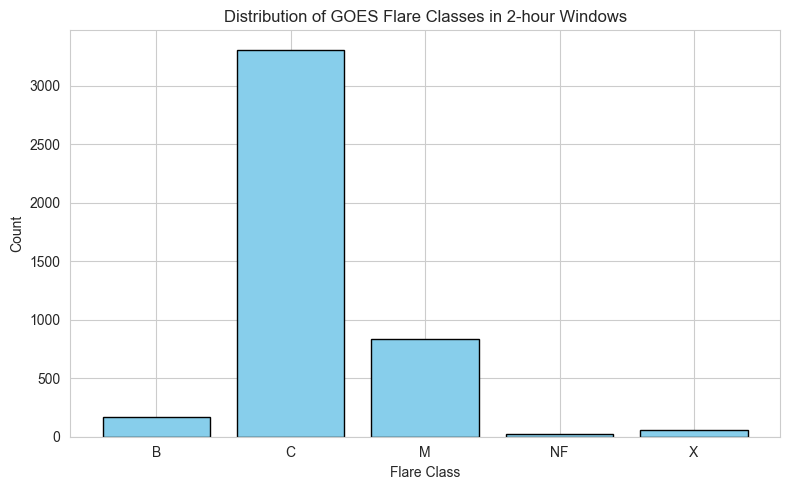

In [64]:
# Count of each flare type
flare_counts = label_df['label'].value_counts().sort_index()  # sort by label

plt.figure(figsize=(8,5))
plt.bar(flare_counts.index, flare_counts.values, color='skyblue', edgecolor='black')
plt.xlabel("Flare Class")
plt.ylabel("Count")
plt.title("Distribution of GOES Flare Classes in 2-hour Windows")
plt.tight_layout()
plt.show()



In [65]:
features_file = "../../data/processed/goes18_2024_mean_features_custom_windows.csv"
features_df = pd.read_csv(features_file)
combined_df = pd.merge(features_df, label_df, on="input_filename", how="inner")

print("Combined dataset shape:", combined_df.shape)
print(combined_df.head())

# Optionally, save to CSV
combined_file = "../../data/processed/goes18_2024_features_labels.csv"
combined_df.to_csv(combined_file, index=False)
print(f"✅ Combined dataset saved to: {combined_file}")


Combined dataset shape: (3888, 128)
                             input_filename  xrsa[0:120]_mean  \
0  GOES18_2024_0000_20240101_0000_input.csv    -15.9544893143   
1  GOES18_2024_0001_20240101_0200_input.csv    -17.4796593227   
2  GOES18_2024_0002_20240101_0400_input.csv    -18.4241442046   
3  GOES18_2024_0003_20240101_0600_input.csv    -17.9753384364   
4  GOES18_2024_0004_20240101_0800_input.csv    -14.3676471708   

   xrsa[0:60]_mean  xrsa[0:30]_mean  xrsa[0:15]_mean  xrsa[0:7]_mean  \
0   -15.6574412051   -15.4247161391   -15.2593308000  -15.1541785720   
1   -17.2868522484   -17.1646074027   -17.1227580664  -17.1096069121   
2   -18.3336280259   -18.1917582244   -18.1551668627  -18.1580654011   
3   -18.2568666702   -18.5583730459   -18.1082726824  -17.6651721381   
4   -13.8413106291   -15.2946328377   -14.8655667403  -14.6606588137   

   xrsa[0:3]_mean  xrsa[3:7]_mean  xrsa[7:15]_mean  xrsa[7:11]_mean  ...  \
0  -15.0953181219  -15.2007152130   -15.3613853877   -15.3128278

In [66]:
binary_map = {'NF': 0,'A': 0,'B': 0,'C': 0,'M': 1,'X': 1}
combined_df['binary_label'] = combined_df['label'].map(binary_map)
print(combined_df['binary_label'].value_counts())
print(combined_df[['label', 'binary_label']].head())
combined_file = "../../data/processed/goes18_2024_features_labels.csv"
combined_df.to_csv(combined_file, index=False)
print(f"✅ Combined dataset saved to: {combined_file}")


binary_label
0    3071
1     817
Name: count, dtype: int64
  label  binary_label
0     C             0
1     C             0
2     C             0
3     M             1
4     C             0
✅ Combined dataset saved to: ../../data/processed/goes18_2024_features_labels.csv


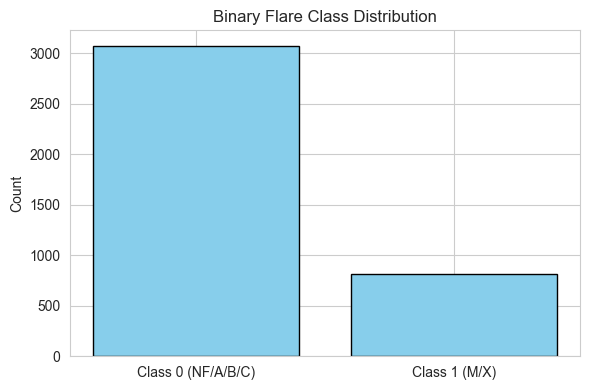

In [67]:
binary_counts = combined_df['binary_label'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6,4))
plt.bar(binary_counts.index, binary_counts.values, color="skyblue", edgecolor='black')
plt.xticks([0, 1], ["Class 0 (NF/A/B/C)", "Class 1 (M/X)"])
plt.ylabel("Count")
plt.title("Binary Flare Class Distribution")
plt.tight_layout()
plt.show()

In [68]:
def split_df_by_percentage(df, train_frac=0.7, val_frac=0.15, test_frac=0.15, random_state=42):
    if abs(train_frac + val_frac + test_frac - 1.0) > 1e-6:
        raise ValueError("Fractions must sum to 1.0")

    train_df, temp_df = train_test_split(df, train_size=train_frac, random_state=random_state, shuffle=True)
    temp_frac = test_frac / (val_frac + test_frac)
    val_df, test_df = train_test_split(temp_df, test_size=temp_frac, random_state=random_state, shuffle=True)
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)


train_df, val_df, test_df = split_df_by_percentage(combined_df)

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)


Train shape: (2721, 129)
Validation shape: (583, 129)
Test shape: (584, 129)


In [69]:
feature_cols = [c for c in train_df.columns if c not in ['input_filename', 'label', 'binary_label']]
mm_scaler = MinMaxScaler()
scaled_train_df = mm_scaler.fit_transform(train_df[feature_cols].values)
scaled_test_df = mm_scaler.fit_transform(test_df[feature_cols].values)
scaled_val_df = mm_scaler.fit_transform(val_df[feature_cols].values)

# X_train = train_df[feature_cols].values * scale_factor
# y_train = train_df['binary_label'].values
#
# X_val = val_df[feature_cols].values * scale_factor
# y_val = val_df['binary_label'].values
#
# X_test = test_df[feature_cols].values *scale_factor
# y_test = test_df['binary_label'].values

X_train = train_df[feature_cols].values
y_train = train_df['binary_label'].values

X_val = val_df[feature_cols].values
y_val = val_df['binary_label'].values

X_test = test_df[feature_cols].values
y_test = test_df['binary_label'].values


X_train = mm_scaler.fit_transform(X_train)
X_val = mm_scaler.transform(X_val)
X_test = mm_scaler.transform(X_test)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Shapes:
X_train: (2721, 126) y_train: (2721,)
X_val: (583, 126) y_val: (583,)
X_test: (584, 126) y_test: (584,)


In [70]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6, 7, 8]
}
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid,cv=cv,scoring=scorer,n_jobs=-1,verbose=1)

grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score from cross-validation
print("Best parameters found:", grid_search.best_params_)
print("Best F1 score (for positive class) from CV:", grid_search.best_score_)

# Retrieve the best estimator and evaluate on the test data
best_rf = grid_search.best_estimator_
Y_pred = best_rf.predict(X_train)

# Save model
joblib.dump(best_rf, '../../models/RandomForestClassifier_model_goes18_xrs_cfe.pkl')

# Output the test classification report and confusion matrix
print("\nTest Classification Report:\n", classification_report(y_train, Y_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_train, Y_pred))

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best parameters found: {'max_depth': 4, 'n_estimators': 300}
Best F1 score (for positive class) from CV: 0.5362781484037523

Test Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.83      0.86      2154
           1       0.50      0.65      0.57       567

    accuracy                           0.79      2721
   macro avg       0.70      0.74      0.72      2721
weighted avg       0.82      0.79      0.80      2721

Test Confusion Matrix:
 [[1793  361]
 [ 199  368]]


In [71]:
overall_results = []
overall_results.append(('training set', TSS(y_train, Y_pred), HSS(y_train, Y_pred),accuracy_score(y_train, Y_pred),precision_score(y_train, Y_pred),f1_score(y_train, Y_pred),recall_score(y_train, Y_pred)))

y_val_pred = best_rf.predict(X_val)
overall_results.append(('validation set', TSS(y_val, y_val_pred), HSS(y_val, y_val_pred),accuracy_score(y_val, y_val_pred),precision_score(y_val, y_val_pred),f1_score(y_val, y_val_pred),recall_score(y_val, y_val_pred)))

y_test_pred = best_rf.predict(X_test)
overall_results.append(('testing set', TSS(y_test, y_test_pred), HSS(y_test, y_test_pred),accuracy_score(y_test, y_test_pred),precision_score(y_test, y_test_pred),f1_score(y_test, y_test_pred),recall_score(y_test, y_test_pred)))
print(pd.DataFrame(overall_results, columns=["Dataset",  "TSS", "HSS","Accuracy","Precision Score","F1_score","Recall_score"]))


          Dataset          TSS          HSS     Accuracy  Precision Score  \
0    training set 0.4814348106 0.4355880032 0.7941933113     0.5048010974   
1  validation set 0.4235405220 0.3906405891 0.7735849057     0.4873417722   
2     testing set 0.5295933575 0.4663042459 0.7996575342     0.5149700599   

      F1_score  Recall_score  
0 0.5679012346  0.6490299824  
1 0.5384615385  0.6015625000  
2 0.5951557093  0.7049180328  


                Feature   Importance
125  xrsb[116:120]_mean 0.0925615109
123  xrsb[112:120]_mean 0.0838768975
62   xrsa[116:120]_mean 0.0689057835
119  xrsb[105:120]_mean 0.0520684564
124  xrsb[112:116]_mean 0.0514130094
111   xrsb[90:120]_mean 0.0484817647
60   xrsa[112:120]_mean 0.0432451798
48    xrsa[90:120]_mean 0.0388688483
122  xrsb[108:112]_mean 0.0283005879
61   xrsa[112:116]_mean 0.0274411688
56   xrsa[105:120]_mean 0.0250323118
95    xrsb[60:120]_mean 0.0236383683
120  xrsb[105:112]_mean 0.0215602279
63     xrsb[0:120]_mean 0.0207834200
32    xrsa[60:120]_mean 0.0187327622
59   xrsa[108:112]_mean 0.0169607593
0      xrsa[0:120]_mean 0.0163292797
112   xrsb[90:105]_mean 0.0109641679
105    xrsb[75:82]_mean 0.0101353562
57   xrsa[105:112]_mean 0.0101122496


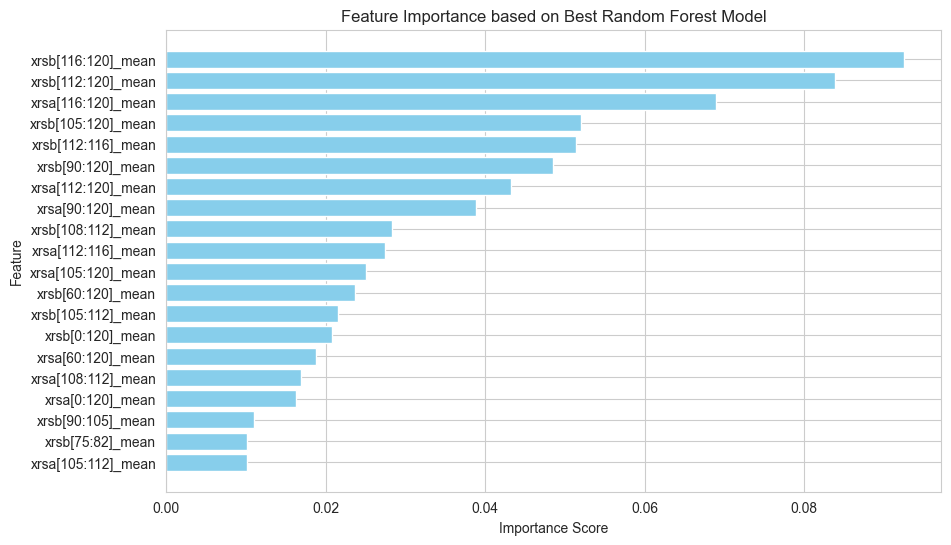

In [72]:
feature_importances = best_rf.feature_importances_
cont_features = list(combined_df.drop(["input_filename","label","binary_label"],axis=1).columns)
feature_importance_df = pd.DataFrame({
    'Feature': cont_features,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)
print(feature_importance_df)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance based on Best Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

Creating DiCE Counterfactual Explainers for SEP Prediction

In [73]:
df_cfe=combined_df.drop(["input_filename","label",],axis=1)
# df_cfe = test_df.drop(["label","input_filename"],axis=1)
df_cfe['binary_label']=df_cfe['binary_label'].astype(float)
# --- Clean continuous features so every column has a visible decimal part ---
for col in cont_features:
    # Force float, replace inf/nan
    df_cfe[col] = pd.to_numeric(df_cfe[col], errors='coerce').fillna(0).astype(float)
    # Round and force decimal representation
    df_cfe[col] = df_cfe[col].apply(lambda x: float(f"{x:.10f}"))
print(df_cfe.dtypes)       # all float64
print(df_cfe.isna().sum()) # all zeros
print(df_cfe.head())
print(df_cfe.columns)


xrsa[0:120]_mean      float64
xrsa[0:60]_mean       float64
xrsa[0:30]_mean       float64
xrsa[0:15]_mean       float64
xrsa[0:7]_mean        float64
                       ...   
xrsb[108:112]_mean    float64
xrsb[112:120]_mean    float64
xrsb[112:116]_mean    float64
xrsb[116:120]_mean    float64
binary_label          float64
Length: 127, dtype: object
xrsa[0:120]_mean      0
xrsa[0:60]_mean       0
xrsa[0:30]_mean       0
xrsa[0:15]_mean       0
xrsa[0:7]_mean        0
                     ..
xrsb[108:112]_mean    0
xrsb[112:120]_mean    0
xrsb[112:116]_mean    0
xrsb[116:120]_mean    0
binary_label          0
Length: 127, dtype: int64
   xrsa[0:120]_mean  xrsa[0:60]_mean  xrsa[0:30]_mean  xrsa[0:15]_mean  \
0    -15.9544893143   -15.6574412051   -15.4247161391   -15.2593308000   
1    -17.4796593227   -17.2868522484   -17.1646074027   -17.1227580664   
2    -18.4241442046   -18.3336280259   -18.1917582244   -18.1551668627   
3    -17.9753384364   -18.2568666702   -18.5583730459   -

In [74]:
df_cfe.head()

,xrsa[0:120]_mean,xrsa[0:60]_mean,xrsa[0:30]_mean,xrsa[0:15]_mean,xrsa[0:7]_mean,xrsa[0:3]_mean,xrsa[3:7]_mean,xrsa[7:15]_mean,xrsa[7:11]_mean,xrsa[11:15]_mean,...,xrsb[97:101]_mean,xrsb[101:105]_mean,xrsb[105:120]_mean,xrsb[105:112]_mean,xrsb[105:108]_mean,xrsb[108:112]_mean,xrsb[112:120]_mean,xrsb[112:116]_mean,xrsb[116:120]_mean,binary_label
0,-15.9544893143,-15.6574412051,-15.4247161391,-15.2593308000,-15.1541785720,-15.0953181219,-15.2007152130,-15.3613853877,-15.3128278471,-15.4124216349,...,-12.5375620392,-13.0975662703,-13.2568718796,-13.2323983888,-13.2161760673,-13.2447401999,-13.2787888071,-13.2672328900,-13.2904798262,0.0000000000
1,-17.4796593227,-17.2868522484,-17.1646074027,-17.1227580664,-17.1096069121,-17.0797542759,-17.1325961718,-17.1344089347,-17.1308457220,-17.1379848892,...,-13.5937644827,-13.5883645472,-13.5809160149,-13.6101676566,-13.6037539121,-13.6150051057,-13.5560044414,-13.5566303172,-13.5553789571,0.0000000000
2,-18.4241442046,-18.3336280259,-18.1917582244,-18.1551668627,-18.1580654011,-18.1090059135,-18.1965070234,-18.1526375152,-18.1534720883,-18.1518036380,...,-13.7351672570,-13.7719992070,-13.7982306394,-13.7953684365,-13.7763592062,-13.8098663167,-13.8007418049,-13.8267577714,-13.7753855423,0.0000000000
3,-17.9753384364,-18.2568666702,-18.5583730459,-18.1082726824,-17.6651721381,-17.6571604249,-17.6712233293,-18.7773866116,-18.4845004488,-19.1933418595,...,-13.7147093904,-13.7066435074,-13.5185094182,-13.6817913705,-13.7085679045,-13.6621692341,-13.3946848634,-13.5779330591,-13.2398728239,1.0000000000
4,-14.3676471708,-13.8413106291,-15.2946328377,-14.8655667403,-14.6606588137,-14.8128125490,-14.5600374682,-15.0874430222,-14.8911666456,-15.3318908712,...,-13.4620449936,-13.5586840409,-13.6743817589,-13.6300343039,-13.6133880896,-13.6427033696,-13.7148676791,-13.7057602764,-13.7240587895,0.0000000000


In [75]:
# import dice_ml.data_interfaces.public_data_interface as pdi
#
# def safe_get_decimal_precisions(self, output_type="dict"):
#     precisions = {}
#     for col in self.data_df.columns:
#         if self.data_df[col].dtype in [np.float32, np.float64]:
#             modes = self.data_df[col].mode()
#             if len(modes) == 0:
#                 precisions[col] = 6
#                 continue
#             val_str = str(modes[0])
#             precisions[col] = len(val_str.split('.')[1]) if '.' in val_str else 6
#         else:
#             precisions[col] = 6
#     return precisions
#
# pdi.PublicData.get_decimal_precisions = safe_get_decimal_precisions
# print("✅ Patched DiCE precision function safely.")


In [76]:
for feat in cont_features:
    df_cfe[feat]=df_cfe[feat].astype(float)

# Ensure column names are strings to avoid mismatches with DiCE internals
# and update cont_features to be string-typed as well
df_cfe.columns = df_cfe.columns.map(str)
cont_features = [str(c) for c in cont_features]

# Create Data object
data= dice_ml.Data(dataframe=df_cfe, continuous_features=cont_features, outcome_name="binary_label")

In [77]:
# Create model wrapper
cfe_model = dice_ml.Model(
    model=best_rf,
    backend="sklearn",
    model_type='classifier'
)
exp_genetic = dice_ml.Dice(
    data_interface=data,
    model_interface=cfe_model,
    method="genetic"
)
joblib.dump(exp_genetic, "../../models/goes18_xrs_2024_cfe_genetic_explainer.pkl")
print("\nGenetic Dice explainer created successfully.\n")


exp_random = dice_ml.Dice(
    data_interface=data,
    model_interface=cfe_model,
    method="random"
)
joblib.dump(exp_random, "../../models/goes18_xrs_2024_cfe_random_explainer.pkl")

print("\nRandom Dice explainer created successfully.\n")


Genetic Dice explainer created successfully.


Random Dice explainer created successfully.



In [78]:
def get_filtered_min_max(df, feature_cols):
    min_max_dict = {}
    for col in feature_cols:
        min_val = df[col].min()
        max_val = df[col].max()
        min_max_dict[col] = [min_val, max_val]
    return min_max_dict

In [79]:
df = pd.read_csv("../../data/processed/goes18_2024_features_labels.csv")
df[cont_features] = df[cont_features].astype(float)*scale_factor
min_max_dict = get_filtered_min_max(df, cont_features)
print(min_max_dict)

{'xrsa[0:120]_mean': [-2072231142.3377302, -1019829753.0195911], 'xrsa[0:60]_mean': [-2072326583.694641, -975769530.5526733], 'xrsa[0:30]_mean': [-2072326583.694641, -939549457.4770362], 'xrsa[0:15]_mean': [-2072326583.694641, -980579854.0156498], 'xrsa[0:7]_mean': [-2072326583.694641, -966976013.9832766], 'xrsa[0:3]_mean': [-2072326583.694641, -960353525.8102298], 'xrsa[3:7]_mean': [-2072326583.694641, -972247573.6411481], 'xrsa[7:15]_mean': [-2072326583.694641, -986181250.0373029], 'xrsa[7:11]_mean': [-2072326583.694641, -968061174.9063171], 'xrsa[11:15]_mean': [-2072326583.694641, -998099256.039533], 'xrsa[15:30]_mean': [-2072326583.694641, -870712447.4875731], 'xrsa[15:22]_mean': [-2072326583.694641, -838143150.9611639], 'xrsa[15:18]_mean': [-2072326583.694641, -869223807.7511951], 'xrsa[18:22]_mean': [-2072326583.694641, -819881142.6523573], 'xrsa[22:30]_mean': [-2072326583.694641, -911790313.3299766], 'xrsa[22:26]_mean': [-2072326583.694641, -883735090.1607869], 'xrsa[26:30]_mean

In [89]:
def get_query_instance(query_ts_filename, df_combined_labels, model):
    """
    Retrieve the query instance and its target label for a given filename.

    Args:
           query_ts_filename (str): The filename identifying the query instance.
           df_combined_labels (pd.DataFrame): DataFrame containing labeled data.
           model: A trained classifier with a `.predict()` method.

    Returns:
        Tuple[pd.DataFrame, Any]: The query instance (features only) and its true label.
     """
    query_instance_raw = df_combined_labels[df_combined_labels['input_filename'] == query_ts_filename]
    query_instance = query_instance_raw.drop(["label", 'input_filename','binary_label'], axis=1)
    query_instance = query_instance.fillna(0)
    true_label = query_instance_raw["binary_label"].values[0]
    predicted_label = model.predict(query_instance)

    print("Target value for the query instance:\n", true_label)
    print("Predicted value:\n", predicted_label)

    return query_instance, true_label, predicted_label

In [91]:
query_ts1_filename ='GOES18_2024_3628_20241029_0800_input.csv'
# query_ts1_filename ='GOES18_2024_4390_20241231_2000_input.csv'
# query_ts1_filename ='GOES18_2024_0026_20240103_0400_input.csv'
query_instance1, target_val1,predicted_val= get_query_instance(query_ts1_filename, df_combined_labels=combined_df, model=best_rf)
query_instance1 = query_instance1.astype(float)
query_instance1 = query_instance1.fillna(0)
print(query_instance1)

Target value for the query instance:
 0
Predicted value:
 [0]
      xrsa[0:120]_mean  xrsa[0:60]_mean  xrsa[0:30]_mean  xrsa[0:15]_mean  \
3164    -15.8098607956   -15.5952509342   -15.2667989267   -15.1813607564   

      xrsa[0:7]_mean  xrsa[0:3]_mean  xrsa[3:7]_mean  xrsa[7:15]_mean  \
3164  -15.1452198753  -15.1387453410  -15.1501034350   -15.2140923007   

      xrsa[7:11]_mean  xrsa[11:15]_mean  ...  xrsb[97:105]_mean  \
3164   -15.1797844980    -15.2496190727  ...     -12.4544022763   

      xrsb[97:101]_mean  xrsb[101:105]_mean  xrsb[105:120]_mean  \
3164     -12.4446157512      -12.4642855249      -12.5368158378   

      xrsb[105:112]_mean  xrsb[105:108]_mean  xrsb[108:112]_mean  \
3164      -12.5340761116      -12.5058763153      -12.5557604068   

      xrsb[112:120]_mean  xrsb[112:116]_mean  xrsb[116:120]_mean  
3164      -12.5392192711      -12.5584989990      -12.5203042312  

[1 rows x 126 columns]


In [ ]:
# Generate counterfactuals
cfe_genetic = exp_genetic.generate_counterfactuals(
    query_instance1,
    total_CFs=4,
    permitted_range=min_max_dict,
    desired_class=1
)
cfe_genetic.visualize_as_dataframe(show_only_changes=True)
cfe_df_genetic = cfe_genetic.cf_examples_list[0].final_cfs_df

  0%|          | 0/1 [00:00<?, ?it/s]

Query instance (original outcome : 0)


,xrsa[0:120]_mean,xrsa[0:60]_mean,xrsa[0:30]_mean,xrsa[0:15]_mean,xrsa[0:7]_mean,xrsa[0:3]_mean,xrsa[3:7]_mean,xrsa[7:15]_mean,xrsa[7:11]_mean,xrsa[11:15]_mean,...,xrsb[97:101]_mean,xrsb[101:105]_mean,xrsb[105:120]_mean,xrsb[105:112]_mean,xrsb[105:108]_mean,xrsb[108:112]_mean,xrsb[112:120]_mean,xrsb[112:116]_mean,xrsb[116:120]_mean,binary_label
0,-1446667648.0000000000,-1699067776.0000000000,-1701977600.0000000000,-1686546048.0000000000,-1681383808.0000000000,-1681268352.0000000000,-1681470336.0000000000,-1691292416.0000000000,-1685987328.0000000000,-1696894720.0000000000,...,-1107578240.0000000000,-1089248512.0000000000,-1080906624.0000000000,-1079634432.0000000000,-1081124992.0000000000,-1078530944.0000000000,-1082033280.0000000000,-1079808000.0000000000,-1084309120.0000000000,0



Diverse Counterfactual set (new outcome: 0)


,xrsa[0:120]_mean,xrsa[0:60]_mean,xrsa[0:30]_mean,xrsa[0:15]_mean,xrsa[0:7]_mean,xrsa[0:3]_mean,xrsa[3:7]_mean,xrsa[7:15]_mean,xrsa[7:11]_mean,xrsa[11:15]_mean,...,xrsb[97:101]_mean,xrsb[101:105]_mean,xrsb[105:120]_mean,xrsb[105:112]_mean,xrsb[105:108]_mean,xrsb[108:112]_mean,xrsb[112:120]_mean,xrsb[112:116]_mean,xrsb[116:120]_mean,binary_label
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [83]:
cfe_exp=[]
cfe_random = exp_random.generate_counterfactuals(
    query_instance1,  #multiple query instances can be provided as an input dataframe
    total_CFs=4,  # Number of counterfactual examples to generate
    permitted_range=min_max_dict,
    desired_class=0#'opposite' #,  # Specify the desired class for a continuous target variable
    )
cfe_random.visualize_as_dataframe(show_only_changes=True)
cfe_df = cfe_random.cf_examples_list[0].final_cfs_df



100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

Query instance (original outcome : 0)


,xrsa[0:120]_mean,xrsa[0:60]_mean,xrsa[0:30]_mean,xrsa[0:15]_mean,xrsa[0:7]_mean,xrsa[0:3]_mean,xrsa[3:7]_mean,xrsa[7:15]_mean,xrsa[7:11]_mean,xrsa[11:15]_mean,...,xrsb[97:101]_mean,xrsb[101:105]_mean,xrsb[105:120]_mean,xrsb[105:112]_mean,xrsb[105:108]_mean,xrsb[108:112]_mean,xrsb[112:120]_mean,xrsb[112:116]_mean,xrsb[116:120]_mean,binary_label
0,-1446667648.0000000000,-1699067776.0000000000,-1701977600.0000000000,-1686546048.0000000000,-1681383808.0000000000,-1681268352.0000000000,-1681470336.0000000000,-1691292416.0000000000,-1685987328.0000000000,-1696894720.0000000000,...,-1107578240.0000000000,-1089248512.0000000000,-1080906624.0000000000,-1079634432.0000000000,-1081124992.0000000000,-1078530944.0000000000,-1082033280.0000000000,-1079808000.0000000000,-1084309120.0000000000,0



Diverse Counterfactual set (new outcome: 0)


,xrsa[0:120]_mean,xrsa[0:60]_mean,xrsa[0:30]_mean,xrsa[0:15]_mean,xrsa[0:7]_mean,xrsa[0:3]_mean,xrsa[3:7]_mean,xrsa[7:15]_mean,xrsa[7:11]_mean,xrsa[11:15]_mean,...,xrsb[97:101]_mean,xrsb[101:105]_mean,xrsb[105:120]_mean,xrsb[105:112]_mean,xrsb[105:108]_mean,xrsb[108:112]_mean,xrsb[112:120]_mean,xrsb[112:116]_mean,xrsb[116:120]_mean,binary_label
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
3,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [84]:
# df_cfe_exp
# --- Ensure data.get_decimal_precisions returns a list indexed by feature positions ---
import types
# keep a resilient reference to the original method (it may be on `data` or on `data.data_interface`)
orig_get_decimals = None
if hasattr(data, 'get_decimal_precisions'):
    orig_get_decimals = data.get_decimal_precisions
elif hasattr(data, 'data_interface') and hasattr(data.data_interface, 'get_decimal_precisions'):
    orig_get_decimals = data.data_interface.get_decimal_precisions


def _bound_get_decimal_precisions(self, output_type='list'):
    """Return a list (default) or dict of decimal precisions aligned with self.feature_names.

    This wrapper is defensive: it attempts to call the original implementation (wherever it lives).
    If none exists or it misbehaves, it falls back to safe defaults (precision=6).
    """
    # 1) Try to call the original implementation if available
    res = None
    if orig_get_decimals is not None:
        try:
            # orig_get_decimals might be a bound method requiring no args, or unbound requiring self
            try:
                res = orig_get_decimals()
            except TypeError:
                res = orig_get_decimals(self)
        except Exception:
            res = None

    # 2) If original returned a dict or list, normalize it
    if isinstance(res, dict):
        flist = [res.get(f, 6) for f in self.feature_names]
        return flist if output_type == 'list' else {f: flist[i] for i, f in enumerate(self.feature_names)}
    if isinstance(res, list):
        return res if output_type == 'list' else {f: res[i] for i, f in enumerate(self.feature_names)}

    # 3) Fallback: compute safe defaults based on data types where possible
    try:
        # default precision
        default_prec = 6
        prec_list = [default_prec] * len(self.feature_names)
        prec_dict = {f: default_prec for f in self.feature_names}
        # compute for continuous features if possible
        for col in getattr(self, 'continuous_feature_names', []):
            try:
                ix = self.feature_names.index(col)
            except ValueError:
                ix = None
            p = default_prec
            try:
                dtype = getattr(self.data_df[col], 'dtype', None)
                if dtype in [np.float32, np.float64]:
                    modes = self.data_df[col].mode()
                    if len(modes) == 0:
                        p = default_prec
                    else:
                        maxp = 0
                        for m in modes:
                            s = str(m)
                            if '.' in s:
                                parts = s.split('.')
                                if len(parts) > 1:
                                    maxp = max(maxp, len(parts[1]))
                        p = maxp if maxp > 0 else default_prec
                else:
                    p = default_prec
            except Exception:
                p = default_prec
            if ix is not None:
                prec_list[ix] = p
            prec_dict[col] = p
        return prec_list if output_type == 'list' else prec_dict
    except Exception:
        # Last-resort fallback
        flist = [6] * len(getattr(self, 'feature_names', []))
        return flist if output_type == 'list' else {f: 6 for f in getattr(self, 'feature_names', [])}

# Bind the wrapper as a proper method to the PublicData or Data instance
try:
    data.get_decimal_precisions = types.MethodType(_bound_get_decimal_precisions, data)
except Exception:
    # As a final fallback, attach to data.data_interface if present
    if hasattr(data, 'data_interface'):
        data.data_interface.get_decimal_precisions = types.MethodType(_bound_get_decimal_precisions, data.data_interface)
